# Ensemble methods

In [1]:
import category_encoders as ce
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from imblearn import over_sampling
from imblearn.pipeline import Pipeline
from sklearn import feature_extraction as fe, metrics, model_selection as ms
from sklearn import ensemble, linear_model as lm
from sklearn import preprocessing
from zipfile import ZipFile

In [2]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)  # Turn off deprecation warnings

In [3]:
SMS_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'

Read in the SMS spam dataset.

In [4]:
with ZipFile(io.BytesIO(requests.get(SMS_URL).content)) as zf:
    sms = pd.read_table(zf.open('SMSSpamCollection'), names=['class', 'text'])

In [5]:
sms.shape

(5572, 2)

In [6]:
sms.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


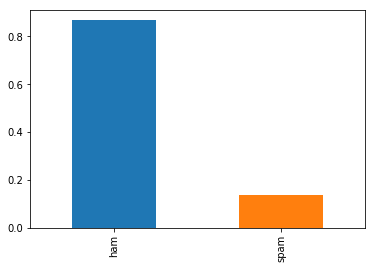

In [7]:
sms['class'].value_counts(normalize=True).plot.bar()

Separate data into `X` and `y`, and define train/validation split.

In [8]:
X = sms['text']
y = (sms['class'] == 'spam').astype(int)

In [9]:
X_train, X_valid, y_train, y_valid = ms.train_test_split(X, y,
                                                         test_size=0.2,
                                                         random_state=42,
                                                         shuffle=True,
                                                         stratify=y)

Define a stratified 3-fold cross-validation split for `GridSearchCV`.

In [10]:
cv = ms.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

## Regularised logistic regression

Define a `Pipeline` that:
1. Vectorises `X` using the tf–idf representation
1. Oversamples the 'spam' category randomly
1. Fits a regularised logistic regression model

In [11]:
lr_pipeline = Pipeline([
    ('tfidf', fe.text.TfidfVectorizer(stop_words='english',
                                      ngram_range=(1, 2),
                                      min_df=0.001)),
    ('oversample', over_sampling.RandomOverSampler(random_state=42)),
    ('lr', lm.LogisticRegression())
])

Find the optimal value of the regularisation parameter `C` using `GridSearchCV`.

In [12]:
lr_gs = ms.GridSearchCV(
    estimator=lr_pipeline,
    param_grid={
        'lr__C': 10.**np.arange(-3, 4),
    },
    scoring='f1',
    n_jobs=-1,
    cv=cv
)

In [13]:
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.001,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'lr__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

Plot $F_{1}$ score vs `C`.

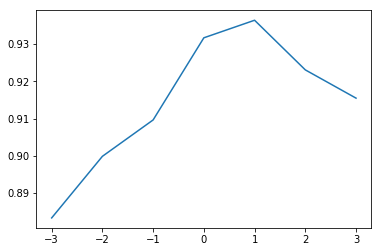

In [14]:
plt.plot(
    np.log10([params['lr__C'] for params in lr_gs.cv_results_['params']]),
    lr_gs.cv_results_['mean_test_score']
)

Check $F_{1}$ score and confusion matrix on the validation set.

In [15]:
metrics.f1_score(y_valid, lr_gs.best_estimator_.predict(X_valid))

0.9261744966442953

In [16]:
metrics.confusion_matrix(y_valid, lr_gs.best_estimator_.predict(X_valid))

array([[955,  11],
       [ 11, 138]])

Plot precision-recall curve.

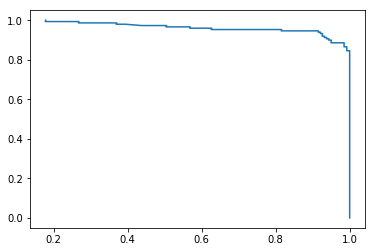

In [17]:
y_pred = lr_gs.best_estimator_.predict_proba(X_valid)[:, 1]
precision, recall, _ = metrics.precision_recall_curve(y_valid, y_pred)
plt.plot(precision, recall)

## Random forest

Same as above, but using `RandomForestClassifier`.

In [18]:
rf_pipeline = Pipeline([
    ('tfidf', fe.text.TfidfVectorizer(stop_words='english',
                                      ngram_range=(1, 2),
                                      min_df=0.001)),
    ('oversample', over_sampling.RandomOverSampler(random_state=42)),
    ('rf', ensemble.RandomForestClassifier(min_samples_leaf=0.001, random_state=42))
])

In [19]:
rf_gs = ms.GridSearchCV(
    estimator=rf_pipeline,
    param_grid={
        'rf__n_estimators': [5, 10, 30, 50, 100, 200, 300, 400, 500],
    },
    scoring='f1',
    n_jobs=-1,
    cv=cv
)

In [20]:
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.001,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [5, 10, 30, 50, 100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

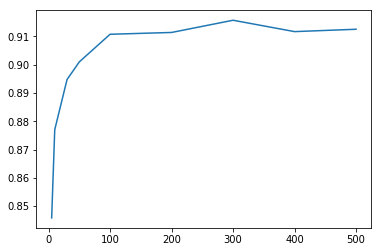

In [21]:
plt.plot(
    [params['rf__n_estimators'] for params in rf_gs.cv_results_['params']],
    rf_gs.cv_results_['mean_test_score']
)

In [22]:
metrics.f1_score(y_valid, rf_gs.best_estimator_.predict(X_valid))

0.8670886075949367

In [23]:
metrics.confusion_matrix(y_valid, rf_gs.best_estimator_.predict(X_valid))

array([[936,  30],
       [ 12, 137]])

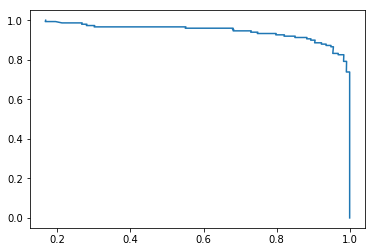

In [24]:
y_pred = rf_gs.best_estimator_.predict_proba(X_valid)[:, 1]
precision, recall, _ = metrics.precision_recall_curve(y_valid, y_pred)
plt.plot(precision, recall)

## XGBoost

In [25]:
from xgboost import XGBClassifier

In [26]:
xgb_pipeline = Pipeline([
    ('tfidf', fe.text.TfidfVectorizer(stop_words='english',
                                      ngram_range=(1, 2),
                                      min_df=0.001)),
    ('oversample', over_sampling.RandomOverSampler(random_state=42)),
    ('xgb', XGBClassifier(random_state=42))
])

In [27]:
xgb_gs = ms.GridSearchCV(
    estimator=xgb_pipeline,
    param_grid={
        'xgb__n_estimators': [5, 10, 30, 50, 100, 200, 300, 400, 500],
    },
    scoring='f1',
    n_jobs=-1,
    cv=cv
)

In [28]:
xgb_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.001,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru...ate=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'xgb__n_estimators': [5, 10, 30, 50, 100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

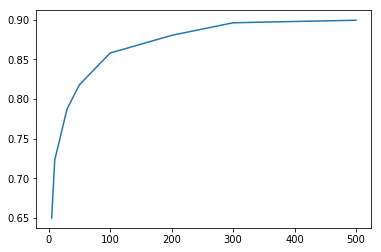

In [29]:
plt.plot(
    [params['xgb__n_estimators'] for params in xgb_gs.cv_results_['params']],
    xgb_gs.cv_results_['mean_test_score']
)

In [30]:
metrics.f1_score(y_valid, xgb_gs.best_estimator_.predict(X_valid))

0.9078498293515358

In [31]:
metrics.confusion_matrix(y_valid, xgb_gs.best_estimator_.predict(X_valid))

array([[955,  11],
       [ 16, 133]])

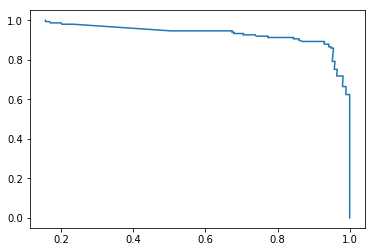

In [32]:
y_pred = xgb_gs.best_estimator_.predict_proba(X_valid)[:, 1]
precision, recall, _ = metrics.precision_recall_curve(y_valid, y_pred)
plt.plot(precision, recall)

## LightGBM

In [33]:
from lightgbm import LGBMClassifier

In [34]:
lgbm_pipeline = Pipeline([
    ('tfidf', fe.text.TfidfVectorizer(stop_words='english',
                                      ngram_range=(1, 2),
                                      min_df=0.001)),
    ('oversample', over_sampling.RandomOverSampler(random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
])

In [35]:
lgbm_gs = ms.GridSearchCV(
    estimator=lgbm_pipeline,
    param_grid={
        'lgbm__n_estimators': [5, 10, 30, 50, 100, 200, 300, 400, 500],
    },
    scoring='f1',
    n_jobs=-1,
    cv=cv
)

In [36]:
lgbm_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.001,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru...0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'lgbm__n_estimators': [5, 10, 30, 50, 100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

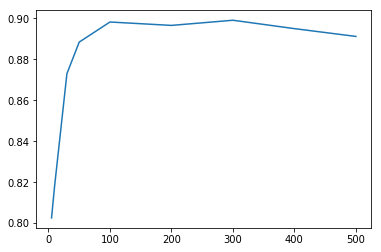

In [37]:
plt.plot(
    [params['lgbm__n_estimators'] for params in lgbm_gs.cv_results_['params']],
    lgbm_gs.cv_results_['mean_test_score']
)

In [38]:
metrics.f1_score(y_valid, lgbm_gs.best_estimator_.predict(X_valid))

0.9020979020979021

In [39]:
metrics.confusion_matrix(y_valid, lgbm_gs.best_estimator_.predict(X_valid))

array([[958,   8],
       [ 20, 129]])

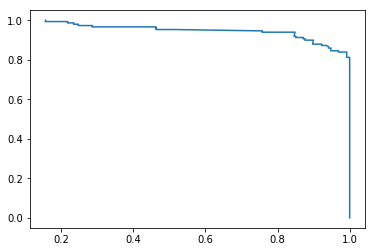

In [40]:
y_pred = lgbm_gs.best_estimator_.predict_proba(X_valid)[:, 1]
precision, recall, _ = metrics.precision_recall_curve(y_valid, y_pred)
plt.plot(precision, recall)

## Comparison

Plot all precision-recall curves together.

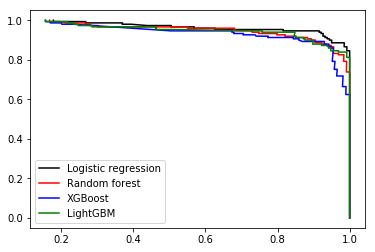

In [41]:
models = [
    {'model': lr_gs.best_estimator_, 'name': 'Logistic regression', 'color': 'black'},
    {'model': rf_gs.best_estimator_, 'name': 'Random forest', 'color': 'red'},
    {'model': xgb_gs.best_estimator_, 'name': 'XGBoost', 'color': 'blue'},
    {'model': lgbm_gs.best_estimator_, 'name': 'LightGBM', 'color': 'green'},
]

for x in models:
    y_pred = x['model'].predict_proba(X_valid)[:, 1]
    precision, recall, _ = metrics.precision_recall_curve(y_valid, y_pred)
    plt.plot(precision, recall, color=x.get('color', 'black'))
plt.legend([x.get('name', '?') for x in models])